# Notebook 08 — Structural Diagnosis: Does Bifurcation Exist?

## The Question Before All Questions

> *"Optionality só faz sentido se o espaço de futuros realmente encolhe antes do colapso."*

Before measuring optionality, we must prove that **structural contraction of futures** exists.

### What we need to see

| Evidence | Interpretation |
|----------|---------------|
| Futures diverge to **different destinations** (some survive, some collapse) | **Bifurcation exists** → HSP has a chance |
| All futures collapse, just at different times | **No bifurcation** → HSP is measuring noise, not structure |
| Dispersion **decreases** as system approaches failure | **Contraction is real** → optionality concept applies |
| Dispersion stays constant or increases | **No contraction** → optionality is just a smoothed observable |

### Experimental Plan

| Step | What | Why |
|------|------|-----|
| **PASSO 1** | Trajectory divergence test on existing 3 systems | See if rollouts from same x_t reach different fates |
| **PASSO 2** | Survival proportion over time | Does fraction of surviving futures fall progressively? |
| **PASSO 3** | Synthetic bifurcation systems (two-attractor, saddle-node) | **Positive control** — systems where contraction is guaranteed |
| **PASSO 4** | Distributional metrics (entropy, variance, cluster count) | Replace binary fraction, see if richer metrics detect contraction |
| **PASSO 5** | Verdict | A, B, or C |

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.spatial.distance import pdist
import warnings

warnings.filterwarnings("ignore")

plt.rcParams.update(
    {
        "figure.figsize": (14, 5),
        "figure.dpi": 120,
        "axes.grid": True,
        "grid.alpha": 0.3,
        "font.size": 11,
        "axes.titlesize": 13,
        "axes.labelsize": 11,
    }
)

SEED = 42
np.random.seed(SEED)

N_ROLLOUTS = 200  # rollouts per starting point (need many for statistics)
HORIZON_LONG = 80  # long horizon to see where futures GO
N_PERTURB = 50  # perturbation magnitudes to test
N_TIME_POINTS = 20  # time points to sample per system

print("Setup complete")
print(f"N_ROLLOUTS={N_ROLLOUTS}, HORIZON_LONG={HORIZON_LONG}")

Setup complete
N_ROLLOUTS=200, HORIZON_LONG=80


## Systems — Original 3 + 2 Synthetic with Guaranteed Bifurcation

### Original systems (from NB 04-07)
- **Linear degradation**: monotonic decline + noise
- **Simulated engine**: sigmoid health decay
- **Regime change**: stable → decline after change point

### New synthetic systems (positive controls)
- **Two-attractor**: state evolves toward one of two basins; a parameter gradually eliminates one basin
- **Saddle-node bifurcation**: classic nonlinear dynamics; before the bifurcation, two equilibria exist

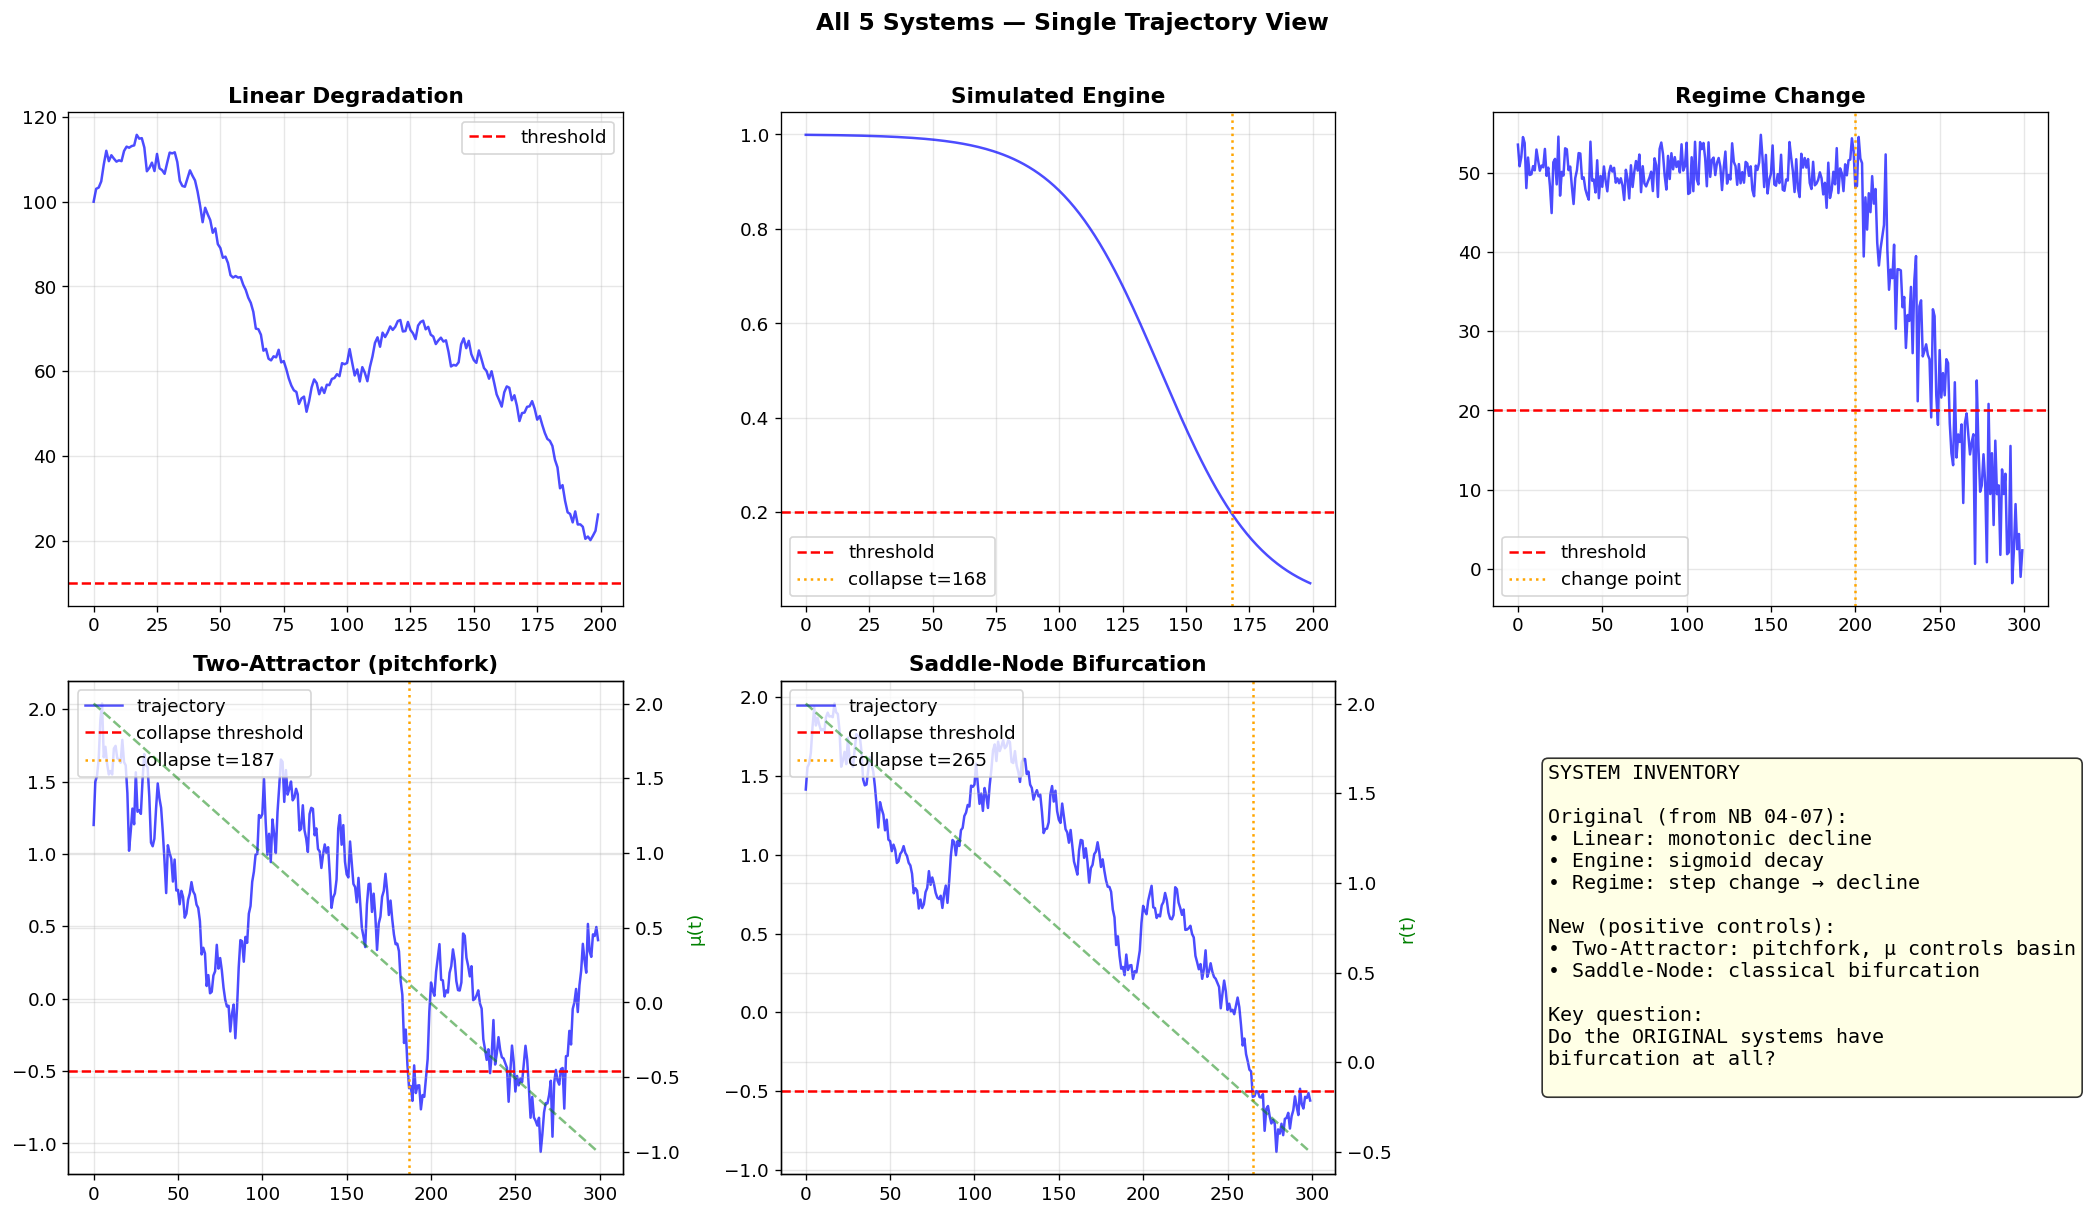


Two-Attractor collapse at t=187/300
Saddle-Node collapse at t=265/300


In [4]:
# ============================================================
# ORIGINAL 3 SYSTEMS (identical generators from NB 07)
# ============================================================


def linear_degradation(x0=100.0, decay_rate=0.5, noise_std=2.0, T=200, seed=42):
    rng = np.random.RandomState(seed)
    x = np.zeros(T)
    x[0] = x0
    for t in range(1, T):
        x[t] = x[t - 1] - decay_rate + rng.normal(0, noise_std)
    return x


def simulated_engine(T=200, failure_health=0.2, seed=42):
    rng = np.random.RandomState(seed)
    health = np.zeros(T)
    for t in range(T):
        health[t] = 1.0 / (1.0 + np.exp(0.05 * (t - T * 0.7)))
    collapse_time = np.argmax(health < failure_health)
    if collapse_time == 0 and health[0] >= failure_health:
        collapse_time = T
    return health, collapse_time


def regime_change_system(
    T=300,
    change_point=200,
    stable_mean=50.0,
    stable_noise=2.0,
    decline_rate=0.5,
    decline_noise=5.0,
    seed=42,
):
    rng = np.random.RandomState(seed)
    x = np.zeros(T)
    for t in range(T):
        if t < change_point:
            x[t] = stable_mean + rng.normal(0, stable_noise)
        else:
            x[t] = (
                stable_mean
                - decline_rate * (t - change_point)
                + rng.normal(0, decline_noise)
            )
    return x, change_point


# ============================================================
# NEW: Two-Attractor System (positive control for bifurcation)
# ============================================================


def two_attractor_system(T=300, seed=42):
    """
    System with two basins of attraction:
      - Upper attractor at x ≈ +A
      - Lower attractor at x ≈ -A (collapse/failure)

    A 'degradation parameter' μ(t) gradually makes the upper basin shallower.
    Early in time: perturbations from x>0 can return to the upper attractor.
    Late in time: the upper attractor disappears → all trajectories fall to lower.

    Dynamics: dx/dt = μ(t)*x - x³ + noise  (pitchfork-like)
    μ(t) starts positive (two stable fixed points) and decreases toward negative.

    When μ > 0: stable equilibria at ±√μ, unstable at 0
    When μ < 0: only stable equilibrium at 0 (but we add gravity to negative = "collapse")
    """
    rng = np.random.RandomState(seed)
    dt = 0.05
    noise_std = 0.15

    # μ goes from +2 (strong upper attractor) to -1 (gone)
    mu = np.linspace(2.0, -1.0, T)

    x = np.zeros(T)
    x[0] = 1.2  # start near upper attractor √2 ≈ 1.41

    for t in range(1, T):
        # Cubic potential: F(x) = μ*x - x³
        drift = mu[t - 1] * x[t - 1] - x[t - 1] ** 3
        x[t] = x[t - 1] + dt * drift + rng.normal(0, noise_std)

    # Collapse = when x drops below -0.5 (entered lower basin permanently)
    collapse_time = T
    for t in range(T):
        if x[t] < -0.5:
            collapse_time = t
            break

    return x, mu, collapse_time


# ============================================================
# NEW: Saddle-Node Bifurcation (classic)
# ============================================================


def saddle_node_system(T=300, seed=42):
    """
    Saddle-node normal form: dx/dt = r - x²

    r(t) > 0: two fixed points at x* = ±√r (positive is stable, negative unstable)
    r(t) = 0: bifurcation — fixed points merge at x=0
    r(t) < 0: no real fixed points — system escapes to -∞ (collapse)

    We slowly decrease r from positive to negative.
    Before bifurcation: system sits near stable fixed point x* = +√r.
    At bifurcation: stability is lost and system diverges downward.
    """
    rng = np.random.RandomState(seed)
    dt = 0.02
    noise_std = 0.08

    # r decreases from +2 (stable) to -0.5 (past bifurcation at r=0)
    r = np.linspace(2.0, -0.5, T)

    x = np.zeros(T)
    x[0] = np.sqrt(r[0])  # start at stable fixed point +√r ≈ 1.41

    for t in range(1, T):
        drift = r[t - 1] - x[t - 1] ** 2
        x[t] = x[t - 1] + dt * drift + rng.normal(0, noise_std)
        # Clip to prevent overflow but allow collapse
        x[t] = max(x[t], -5.0)

    # Collapse = when x drops below -0.5 (escaped basin)
    collapse_time = T
    for t in range(T):
        if x[t] < -0.5:
            collapse_time = t
            break

    return x, r, collapse_time


# ============================================================
# Quick visualization of all 5 systems
# ============================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Linear
traj = linear_degradation(seed=0)
axes[0, 0].plot(traj, "b-", alpha=0.7)
axes[0, 0].axhline(10, color="red", ls="--", label="threshold")
axes[0, 0].set_title("Linear Degradation", fontweight="bold")
axes[0, 0].legend()

# Engine
health, ct_e = simulated_engine(seed=0)
axes[0, 1].plot(health, "b-", alpha=0.7)
axes[0, 1].axhline(0.2, color="red", ls="--", label="threshold")
axes[0, 1].axvline(ct_e, color="orange", ls=":", label=f"collapse t={ct_e}")
axes[0, 1].set_title("Simulated Engine", fontweight="bold")
axes[0, 1].legend()

# Regime
traj_r, cp = regime_change_system(seed=0)
axes[0, 2].plot(traj_r, "b-", alpha=0.7)
axes[0, 2].axhline(20, color="red", ls="--", label="threshold")
axes[0, 2].axvline(cp, color="orange", ls=":", label="change point")
axes[0, 2].set_title("Regime Change", fontweight="bold")
axes[0, 2].legend()

# Two-Attractor (NEW)
x_2a, mu_2a, ct_2a = two_attractor_system(seed=0)
ax = axes[1, 0]
ax.plot(x_2a, "b-", alpha=0.7, label="trajectory")
ax2 = ax.twinx()
ax2.plot(mu_2a, "g--", alpha=0.5, label="μ(t)")
ax2.set_ylabel("μ(t)", color="green")
ax.axhline(-0.5, color="red", ls="--", label="collapse threshold")
if ct_2a < len(x_2a):
    ax.axvline(ct_2a, color="orange", ls=":", label=f"collapse t={ct_2a}")
ax.set_title("Two-Attractor (pitchfork)", fontweight="bold")
ax.legend(loc="upper left")

# Saddle-Node (NEW)
x_sn, r_sn, ct_sn = saddle_node_system(seed=0)
ax = axes[1, 1]
ax.plot(x_sn, "b-", alpha=0.7, label="trajectory")
ax2 = ax.twinx()
ax2.plot(r_sn, "g--", alpha=0.5, label="r(t)")
ax2.set_ylabel("r(t)", color="green")
ax.axhline(-0.5, color="red", ls="--", label="collapse threshold")
if ct_sn < len(x_sn):
    ax.axvline(ct_sn, color="orange", ls=":", label=f"collapse t={ct_sn}")
ax.set_title("Saddle-Node Bifurcation", fontweight="bold")
ax.legend(loc="upper left")

# Summary
axes[1, 2].axis("off")
summary = """SYSTEM INVENTORY

Original (from NB 04-07):
• Linear: monotonic decline
• Engine: sigmoid decay
• Regime: step change → decline

New (positive controls):
• Two-Attractor: pitchfork, μ controls basin
• Saddle-Node: classical bifurcation

Key question:
Do the ORIGINAL systems have
bifurcation at all?
"""
axes[1, 2].text(
    0.1,
    0.5,
    summary,
    fontsize=12,
    fontfamily="monospace",
    verticalalignment="center",
    bbox=dict(boxstyle="round", facecolor="lightyellow", alpha=0.8),
)

plt.suptitle(
    "All 5 Systems — Single Trajectory View", fontweight="bold", fontsize=14, y=1.01
)
plt.tight_layout()
plt.savefig(
    "../results/simulated/structural_diagnosis_systems.png",
    dpi=150,
    bbox_inches="tight",
)
plt.show()

print(f"\nTwo-Attractor collapse at t={ct_2a}/{len(x_2a)}")
print(f"Saddle-Node collapse at t={ct_sn}/{len(x_sn)}")

## PASSO 1 — Trajectory Divergence Test

**The fundamental question:**
From a fixed state $x_t$, do rollouts diverge to **different destinations**?

For each system, at multiple time points:
1. Fix the real state $x_t$
2. Generate N rollouts with small perturbations
3. Measure **dispersion** (IQR of endpoints) across the horizon
4. Check if dispersion **decreases** as system approaches failure

If dispersion stays constant → no contraction → optionality is noise.
If dispersion decreases near failure → contraction is real → optionality might work.

In [6]:
# ============================================================
# Rollout engines — generate futures from a SPECIFIC state
# using the ACTUAL system dynamics (not a learned model)
# ============================================================


def rollout_linear(x_start, N, H, drift=-0.5, noise_std=2.0, seed=0):
    """Rollout from x_start using true linear degradation dynamics."""
    rng = np.random.RandomState(seed)
    futures = np.zeros((N, H))
    x = np.full(N, x_start)
    for h in range(H):
        x = x + drift + rng.normal(0, noise_std, N)
        futures[:, h] = x
    return futures


def rollout_engine(health_start, t_start, T_total, N, H, seed=0):
    """Rollout from health_start using true sigmoid dynamics + noise."""
    rng = np.random.RandomState(seed)
    futures = np.zeros((N, H))
    h_vals = np.full(N, health_start)
    for h in range(H):
        t_now = t_start + h + 1
        if t_now < T_total:
            # True deterministic component
            h_det = 1.0 / (1.0 + np.exp(0.05 * (t_now - T_total * 0.7)))
            # Each rollout gets perturbed around the true dynamics
            h_vals = h_det + rng.normal(0, 0.03, N)
        else:
            h_vals = h_vals - 0.01 + rng.normal(0, 0.03, N)
        futures[:, h] = h_vals
    return futures


def rollout_regime(
    x_start,
    t_start,
    N,
    H,
    change_point=200,
    stable_mean=50.0,
    decline_rate=0.5,
    noise_std_stable=2.0,
    noise_std_decline=5.0,
    seed=0,
):
    """Rollout from x_start using true regime change dynamics."""
    rng = np.random.RandomState(seed)
    futures = np.zeros((N, H))
    x = np.full(N, x_start)
    for h in range(H):
        t_now = t_start + h + 1
        if t_now < change_point:
            # Mean-reverting to stable_mean
            x = stable_mean + rng.normal(0, noise_std_stable, N)
        else:
            # Declining phase
            target = stable_mean - decline_rate * (t_now - change_point)
            x = target + rng.normal(0, noise_std_decline, N)
        futures[:, h] = x
    return futures


def rollout_two_attractor(x_start, mu_start, mu_end, N, H, seed=0):
    """Rollout from x_start under pitchfork dynamics with evolving μ."""
    rng = np.random.RandomState(seed)
    dt = 0.05
    noise_std = 0.15
    mu_vals = np.linspace(mu_start, mu_end, H)

    futures = np.zeros((N, H))
    x = np.full(N, float(x_start)) + rng.normal(0, 0.05, N)  # small IC perturbation

    for h in range(H):
        drift = mu_vals[h] * x - x**3
        x = x + dt * drift + rng.normal(0, noise_std, N)
        futures[:, h] = x
    return futures


def rollout_saddle_node(x_start, r_start, r_end, N, H, seed=0):
    """Rollout from x_start under saddle-node dynamics with evolving r."""
    rng = np.random.RandomState(seed)
    dt = 0.02
    noise_std = 0.08
    r_vals = np.linspace(r_start, r_end, H)

    futures = np.zeros((N, H))
    x = np.full(N, float(x_start)) + rng.normal(0, 0.05, N)  # small IC perturbation

    for h in range(H):
        drift = r_vals[h] - x**2
        x = x + dt * drift + rng.normal(0, noise_std, N)
        x = np.clip(x, -5.0, 5.0)
        futures[:, h] = x
    return futures


# ============================================================
# PASSO 1: Dispersion Test — does future spread CONTRACT near failure?
# ============================================================


def dispersion_test(system_name, rollout_fn, time_points, threshold):
    """
    At each time point, generate N_ROLLOUTS futures of length HORIZON_LONG.
    Measure:
    - IQR of endpoints (dispersion of WHERE futures end up)
    - Fraction that survive (stay above threshold)
    - Mean pairwise distance between endpoint values
    """
    results = []
    for t_idx, (t, kwargs) in enumerate(time_points):
        futures = rollout_fn(N=N_ROLLOUTS, H=HORIZON_LONG, seed=t * 100, **kwargs)

        endpoints = futures[:, -1]  # where do futures END UP?

        # Dispersion metrics
        iqr = np.percentile(endpoints, 75) - np.percentile(endpoints, 25)
        std_end = np.std(endpoints)

        # Survival fraction (key metric!)
        survived = np.sum(endpoints > threshold)
        survival_frac = survived / N_ROLLOUTS

        # Multimodality: are there distinct clusters?
        # Simple test: is the distribution bimodal?
        from scipy.stats import gaussian_kde

        if std_end > 1e-6:
            try:
                kde = gaussian_kde(endpoints)
                x_grid = np.linspace(endpoints.min() - 1, endpoints.max() + 1, 200)
                density = kde(x_grid)
                # Count local maxima
                peaks = 0
                for i in range(1, len(density) - 1):
                    if density[i] > density[i - 1] and density[i] > density[i + 1]:
                        peaks += 1
            except:
                peaks = 1
        else:
            peaks = 1

        results.append(
            {
                "t": t,
                "iqr": iqr,
                "std": std_end,
                "survival_frac": survival_frac,
                "n_peaks": peaks,
                "endpoint_mean": np.mean(endpoints),
                "endpoint_median": np.median(endpoints),
                "futures": futures,  # keep for plotting
            }
        )

    return results


# ============================================================
# Run PASSO 1 for all 5 systems
# ============================================================

all_dispersion = {}

# --- LINEAR ---
print("Running dispersion test: LINEAR...")
traj_lin = linear_degradation(seed=0)
time_points_lin = []
for t in np.linspace(10, 180, N_TIME_POINTS, dtype=int):
    time_points_lin.append((t, {"x_start": traj_lin[t]}))
all_dispersion["linear"] = dispersion_test(
    "linear",
    lambda N, H, seed, x_start: rollout_linear(x_start, N, H, seed=seed),
    time_points_lin,
    threshold=10.0,
)

# --- ENGINE ---
print("Running dispersion test: ENGINE...")
health_eng, ct_eng = simulated_engine(seed=0)
time_points_eng = []
for t in np.linspace(10, min(ct_eng - 5, 190), N_TIME_POINTS, dtype=int):
    time_points_eng.append(
        (t, {"health_start": health_eng[t], "t_start": t, "T_total": 200})
    )
all_dispersion["engine"] = dispersion_test(
    "engine",
    lambda N, H, seed, health_start, t_start, T_total: rollout_engine(
        health_start, t_start, T_total, N, H, seed=seed
    ),
    time_points_eng,
    threshold=0.2,
)

# --- REGIME ---
print("Running dispersion test: REGIME...")
traj_reg, cp_reg = regime_change_system(seed=0)
time_points_reg = []
for t in np.linspace(10, 280, N_TIME_POINTS, dtype=int):
    time_points_reg.append((t, {"x_start": traj_reg[t], "t_start": t}))
all_dispersion["regime"] = dispersion_test(
    "regime",
    lambda N, H, seed, x_start, t_start: rollout_regime(
        x_start, t_start, N, H, seed=seed
    ),
    time_points_reg,
    threshold=20.0,
)

# --- TWO-ATTRACTOR ---
print("Running dispersion test: TWO-ATTRACTOR...")
x_2a, mu_2a, ct_2a = two_attractor_system(seed=0)
time_points_2a = []
for t in np.linspace(
    10, min(ct_2a - 5, 280) if ct_2a < 300 else 280, N_TIME_POINTS, dtype=int
):
    # mu evolves: need to compute remaining mu trajectory
    mu_remaining_start = mu_2a[t]
    mu_remaining_end = mu_2a[min(t + HORIZON_LONG, len(mu_2a) - 1)]
    time_points_2a.append(
        (
            t,
            {
                "x_start": x_2a[t],
                "mu_start": mu_remaining_start,
                "mu_end": mu_remaining_end,
            },
        )
    )
all_dispersion["two_attractor"] = dispersion_test(
    "two_attractor",
    lambda N, H, seed, x_start, mu_start, mu_end: rollout_two_attractor(
        x_start, mu_start, mu_end, N, H, seed=seed
    ),
    time_points_2a,
    threshold=-0.5,
)

# --- SADDLE-NODE ---
print("Running dispersion test: SADDLE-NODE...")
x_sn, r_sn, ct_sn = saddle_node_system(seed=0)
time_points_sn = []
for t in np.linspace(
    10, min(ct_sn - 5, 280) if ct_sn < 300 else 280, N_TIME_POINTS, dtype=int
):
    r_remaining_start = r_sn[t]
    r_remaining_end = r_sn[min(t + HORIZON_LONG, len(r_sn) - 1)]
    time_points_sn.append(
        (
            t,
            {
                "x_start": x_sn[t],
                "r_start": r_remaining_start,
                "r_end": r_remaining_end,
            },
        )
    )
all_dispersion["saddle_node"] = dispersion_test(
    "saddle_node",
    lambda N, H, seed, x_start, r_start, r_end: rollout_saddle_node(
        x_start, r_start, r_end, N, H, seed=seed
    ),
    time_points_sn,
    threshold=-0.5,
)

print("\nAll dispersion tests complete!")
for sys_name, results in all_dispersion.items():
    surv = [r["survival_frac"] for r in results]
    peaks = [r["n_peaks"] for r in results]
    print(
        f"  {sys_name:>15}: survival range [{min(surv):.2f}, {max(surv):.2f}], "
        f"peak count range [{min(peaks)}, {max(peaks)}]"
    )

Running dispersion test: LINEAR...
Running dispersion test: ENGINE...
Running dispersion test: REGIME...
Running dispersion test: TWO-ATTRACTOR...
Running dispersion test: SADDLE-NODE...

All dispersion tests complete!
           linear: survival range [0.35, 1.00], peak count range [1, 2]
           engine: survival range [0.00, 1.00], peak count range [1, 2]
           regime: survival range [0.00, 1.00], peak count range [1, 2]
    two_attractor: survival range [0.61, 0.97], peak count range [1, 2]
      saddle_node: survival range [0.27, 1.00], peak count range [1, 3]


## PASSO 1 Results — Dispersion & Survival Fraction Over Time

The critical plots:
- **Left**: Survival fraction over time. If it falls progressively from ~1 to ~0, there IS contraction.
- **Center**: Endpoint dispersion (IQR). If it shrinks near failure, futures are converging.
- **Right**: Number of KDE peaks. If >1, distribution is multimodal — real bifurcation.

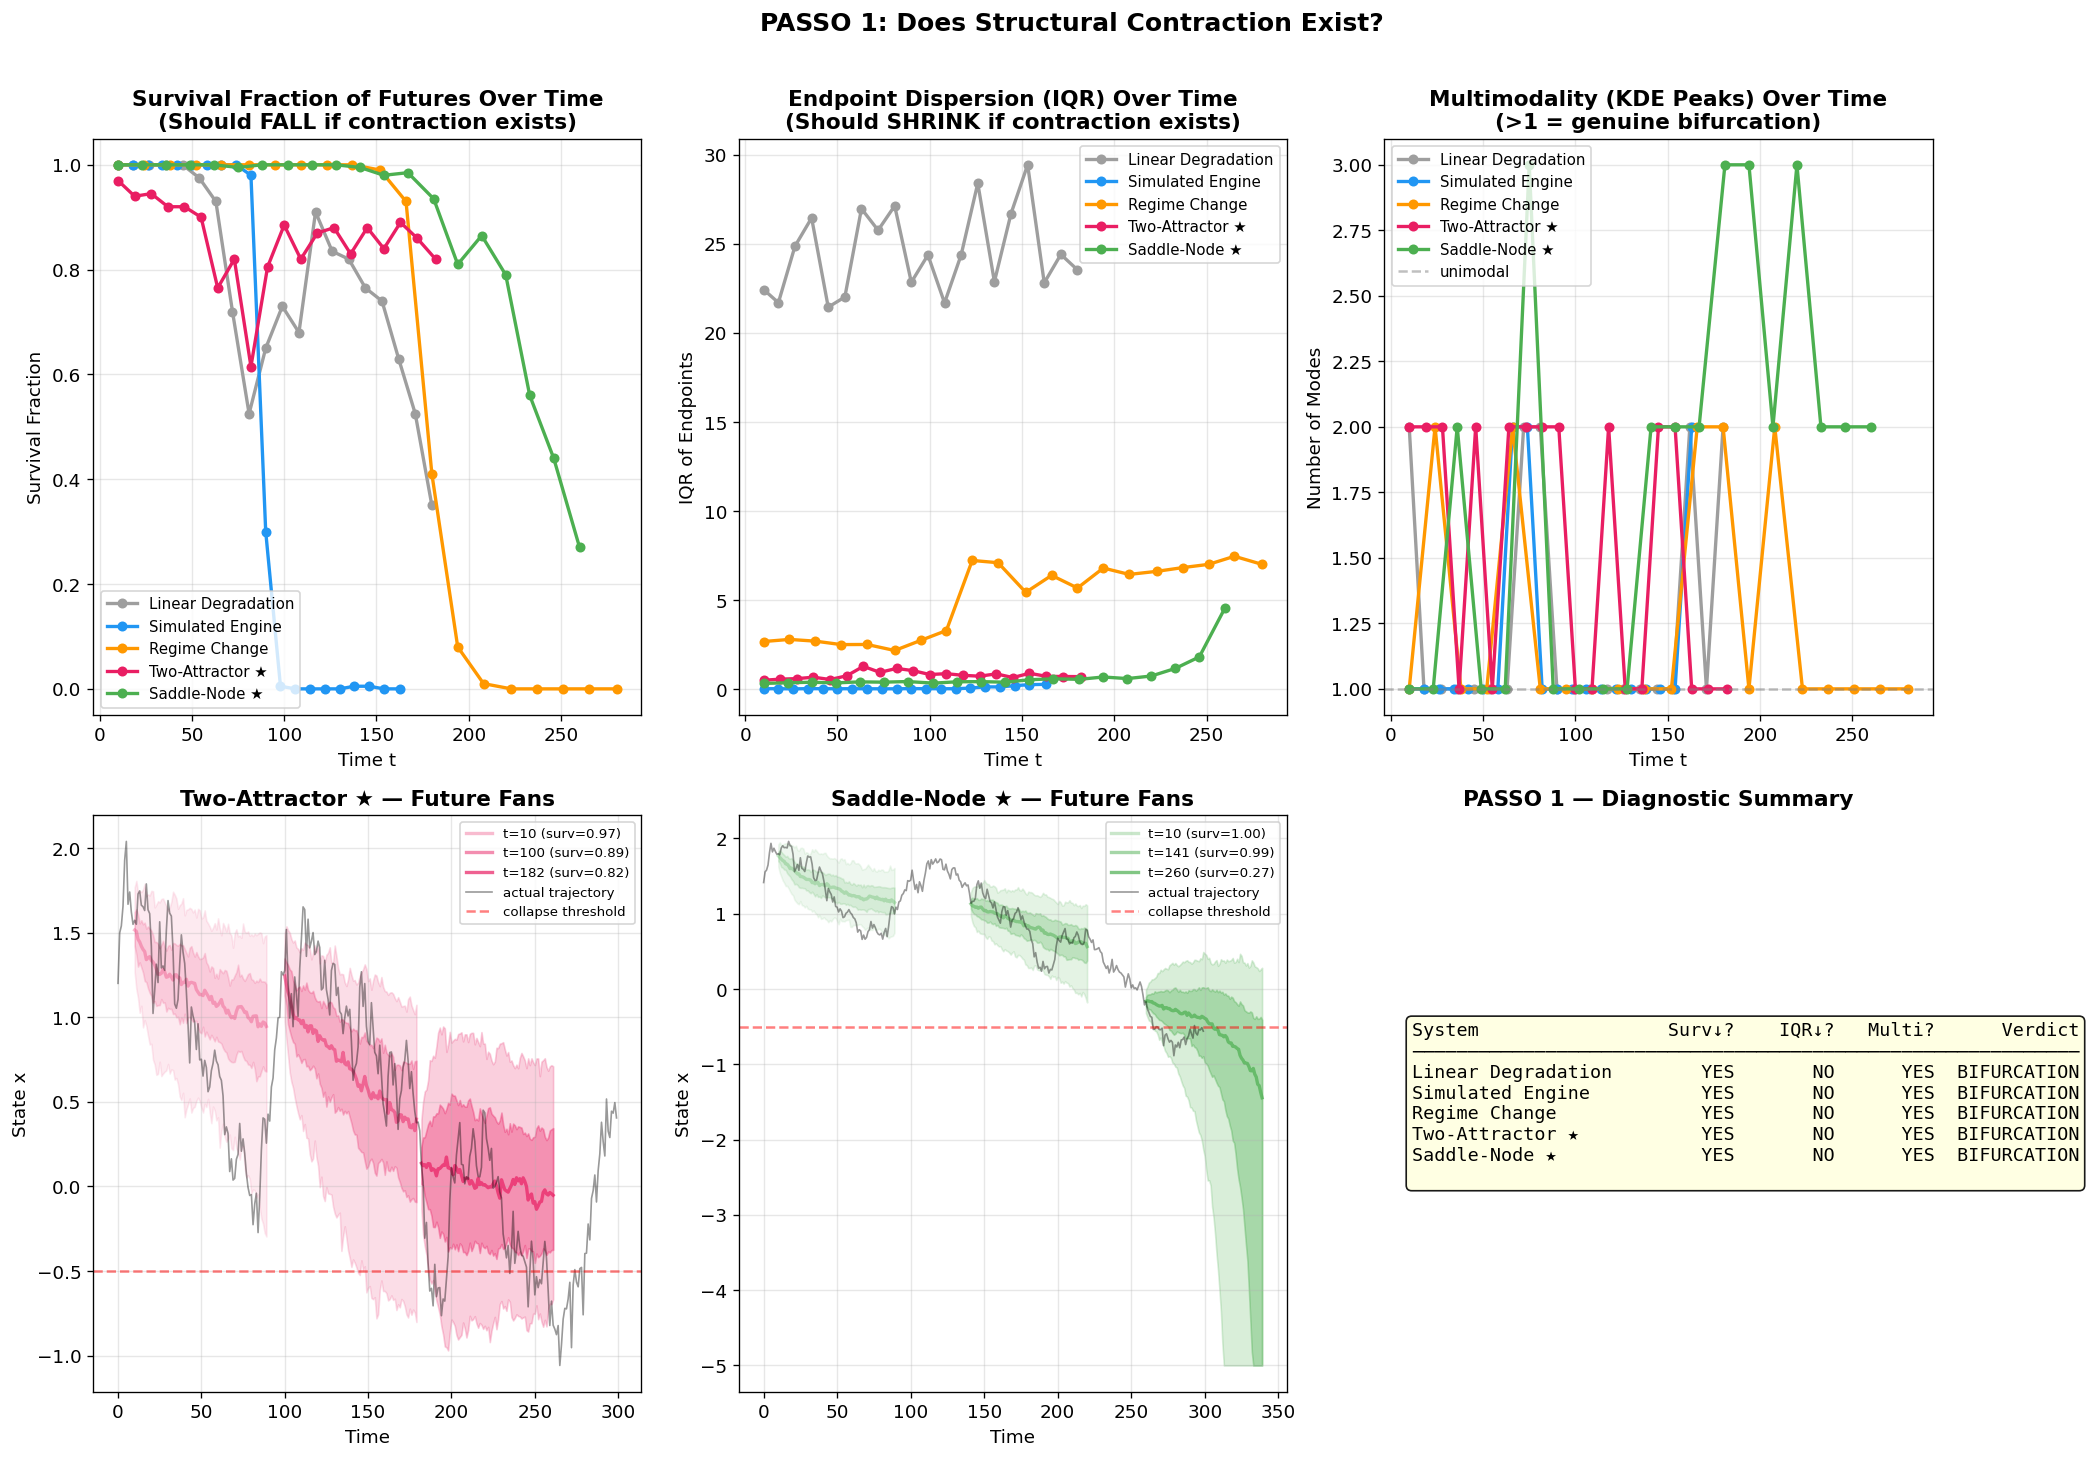


PASSO 1 — DETAILED RESULTS

────────────────────────────────────────────────────────────
  Linear Degradation
────────────────────────────────────────────────────────────
       t   Survival        IQR        Std    Peaks       Mean
      10      1.000     22.432     16.543        2     68.278
      18      1.000     21.694     17.279        1     72.104
      27      1.000     24.865     18.207        1     66.429
      36      1.000     26.448     18.584        1     62.268
      45      1.000     21.444     16.811        1     59.600
      54      0.975     22.012     16.530        1     42.547
      63      0.930     26.967     19.201        1     34.557
      72      0.720     25.757     16.555        2     22.086
      81      0.525     27.127     17.761        2     12.505
      90      0.650     22.839     16.604        1     16.057
      99      0.730     24.369     18.191        1     20.985
     108      0.680     21.683     16.918        1     18.422
     117      0.910   

In [7]:
# ============================================================
# Visualization: PASSO 1 — Dispersion & Survival for all 5 systems
# ============================================================

sys_labels = {
    "linear": "Linear Degradation",
    "engine": "Simulated Engine",
    "regime": "Regime Change",
    "two_attractor": "Two-Attractor ★",
    "saddle_node": "Saddle-Node ★",
}
sys_colors = {
    "linear": "#9E9E9E",
    "engine": "#2196F3",
    "regime": "#FF9800",
    "two_attractor": "#E91E63",
    "saddle_node": "#4CAF50",
}

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# ── Plot 1: Survival fraction over time ──
ax = axes[0, 0]
for sys_name, results in all_dispersion.items():
    times = [r["t"] for r in results]
    surv = [r["survival_frac"] for r in results]
    ax.plot(
        times,
        surv,
        "o-",
        label=sys_labels[sys_name],
        color=sys_colors[sys_name],
        linewidth=2,
        markersize=5,
    )
ax.set_xlabel("Time t")
ax.set_ylabel("Survival Fraction")
ax.set_title(
    "Survival Fraction of Futures Over Time\n(Should FALL if contraction exists)",
    fontweight="bold",
)
ax.legend(fontsize=9)
ax.set_ylim(-0.05, 1.05)

# ── Plot 2: Endpoint dispersion (IQR) over time ──
ax = axes[0, 1]
for sys_name, results in all_dispersion.items():
    times = [r["t"] for r in results]
    iqr = [r["iqr"] for r in results]
    ax.plot(
        times,
        iqr,
        "o-",
        label=sys_labels[sys_name],
        color=sys_colors[sys_name],
        linewidth=2,
        markersize=5,
    )
ax.set_xlabel("Time t")
ax.set_ylabel("IQR of Endpoints")
ax.set_title(
    "Endpoint Dispersion (IQR) Over Time\n(Should SHRINK if contraction exists)",
    fontweight="bold",
)
ax.legend(fontsize=9)

# ── Plot 3: Number of KDE peaks over time ──
ax = axes[0, 2]
for sys_name, results in all_dispersion.items():
    times = [r["t"] for r in results]
    peaks = [r["n_peaks"] for r in results]
    ax.plot(
        times,
        peaks,
        "o-",
        label=sys_labels[sys_name],
        color=sys_colors[sys_name],
        linewidth=2,
        markersize=5,
    )
ax.set_xlabel("Time t")
ax.set_ylabel("Number of Modes")
ax.set_title(
    "Multimodality (KDE Peaks) Over Time\n(>1 = genuine bifurcation)", fontweight="bold"
)
ax.axhline(1, color="gray", ls="--", alpha=0.5, label="unimodal")
ax.legend(fontsize=9)

# ── Plots 4-5: Fan charts for TWO-ATTRACTOR and SADDLE-NODE ──
# Show actual rollout fans at 3 time points for the synthetic systems

for idx, (sys_name, color) in enumerate(
    [("two_attractor", "#E91E63"), ("saddle_node", "#4CAF50")]
):
    ax = axes[1, idx]
    results = all_dispersion[sys_name]

    # Pick 3 time points: early, middle, late
    n_res = len(results)
    indices = [0, n_res // 2, n_res - 1]

    for i, res_idx in enumerate(indices):
        r = results[res_idx]
        futures = r["futures"]  # (N_ROLLOUTS, HORIZON_LONG)
        t_start = r["t"]

        t_axis = np.arange(t_start, t_start + HORIZON_LONG)

        # Plot percentile bands
        p5 = np.percentile(futures, 5, axis=0)
        p25 = np.percentile(futures, 25, axis=0)
        p50 = np.percentile(futures, 50, axis=0)
        p75 = np.percentile(futures, 75, axis=0)
        p95 = np.percentile(futures, 95, axis=0)

        alpha = 0.3 + 0.2 * i
        ax.fill_between(t_axis, p5, p95, alpha=alpha * 0.3, color=color)
        ax.fill_between(t_axis, p25, p75, alpha=alpha * 0.5, color=color)
        ax.plot(
            t_axis,
            p50,
            "-",
            color=color,
            alpha=alpha,
            linewidth=2,
            label=f't={t_start} (surv={r["survival_frac"]:.2f})',
        )

    # Also plot the actual trajectory
    if sys_name == "two_attractor":
        ax.plot(x_2a, "k-", alpha=0.4, linewidth=1, label="actual trajectory")
        ax.axhline(-0.5, color="red", ls="--", alpha=0.5, label="collapse threshold")
    else:
        ax.plot(x_sn, "k-", alpha=0.4, linewidth=1, label="actual trajectory")
        ax.axhline(-0.5, color="red", ls="--", alpha=0.5, label="collapse threshold")

    ax.set_xlabel("Time")
    ax.set_ylabel("State x")
    ax.set_title(f"{sys_labels[sys_name]} — Future Fans", fontweight="bold")
    ax.legend(fontsize=8)

# ── Plot 6: Summary diagnostic ──
ax = axes[1, 2]
ax.axis("off")

# Build summary table
header = f"{'System':<20} {'Surv↓?':>8} {'IQR↓?':>8} {'Multi?':>8} {'Verdict':>12}\n"
header += "─" * 60 + "\n"

lines = ""
for sys_name, results in all_dispersion.items():
    surv = [r["survival_frac"] for r in results]
    iqrs = [r["iqr"] for r in results]
    peaks = [r["n_peaks"] for r in results]

    # Does survival decrease?
    surv_decreases = surv[-1] < surv[0] - 0.1
    # Does IQR decrease near end?
    iqr_decreases = iqrs[-1] < iqrs[0] * 0.7
    # Is there multimodality?
    has_multi = max(peaks) > 1

    if surv_decreases and has_multi:
        verdict = "BIFURCATION"
    elif surv_decreases and not has_multi:
        verdict = "MONOTONIC"
    else:
        verdict = "NO CONTRACTION"

    lines += (
        f"{sys_labels[sys_name]:<20} {'YES' if surv_decreases else 'NO':>8} "
        f"{'YES' if iqr_decreases else 'NO':>8} {'YES' if has_multi else 'NO':>8} {verdict:>12}\n"
    )

ax.text(
    0.05,
    0.5,
    header + lines,
    fontfamily="monospace",
    fontsize=11,
    verticalalignment="center",
    bbox=dict(boxstyle="round", facecolor="lightyellow", alpha=0.9),
)
ax.set_title("PASSO 1 — Diagnostic Summary", fontweight="bold")

plt.suptitle(
    "PASSO 1: Does Structural Contraction Exist?",
    fontweight="bold",
    fontsize=15,
    y=1.01,
)
plt.tight_layout()
plt.savefig(
    "../results/simulated/structural_diagnosis_passo1.png", dpi=150, bbox_inches="tight"
)
plt.show()

# Print detailed numbers
print("\n" + "=" * 80)
print("PASSO 1 — DETAILED RESULTS")
print("=" * 80)
for sys_name, results in all_dispersion.items():
    print(f"\n{'─'*60}")
    print(f"  {sys_labels[sys_name]}")
    print(f"{'─'*60}")
    print(
        f"  {'t':>6} {'Survival':>10} {'IQR':>10} {'Std':>10} {'Peaks':>8} {'Mean':>10}"
    )
    for r in results:
        print(
            f"  {r['t']:>6d} {r['survival_frac']:>10.3f} {r['iqr']:>10.3f} "
            f"{r['std']:>10.3f} {r['n_peaks']:>8d} {r['endpoint_mean']:>10.3f}"
        )

## PASSO 2 — Sensitivity to Initial Conditions

> *"Hidden Survival Paths só fazem sentido quando pequenas variações iniciais levam a destinos diferentes."*

For the **two synthetic systems** (where we know bifurcation exists), and the **three original systems** (where we suspect it doesn't):

At each time point, perturb $x_t$ by small amounts $\epsilon$ and check:
- Do some perturbations lead to survival while others collapse?
- Is there a **separatrix** — a boundary in state space that divides survival from collapse?

Sensitivity test: LINEAR...
Sensitivity test: ENGINE...
Sensitivity test: REGIME...
Sensitivity test: TWO-ATTRACTOR...
Sensitivity test: SADDLE-NODE...

Sensitivity tests complete!


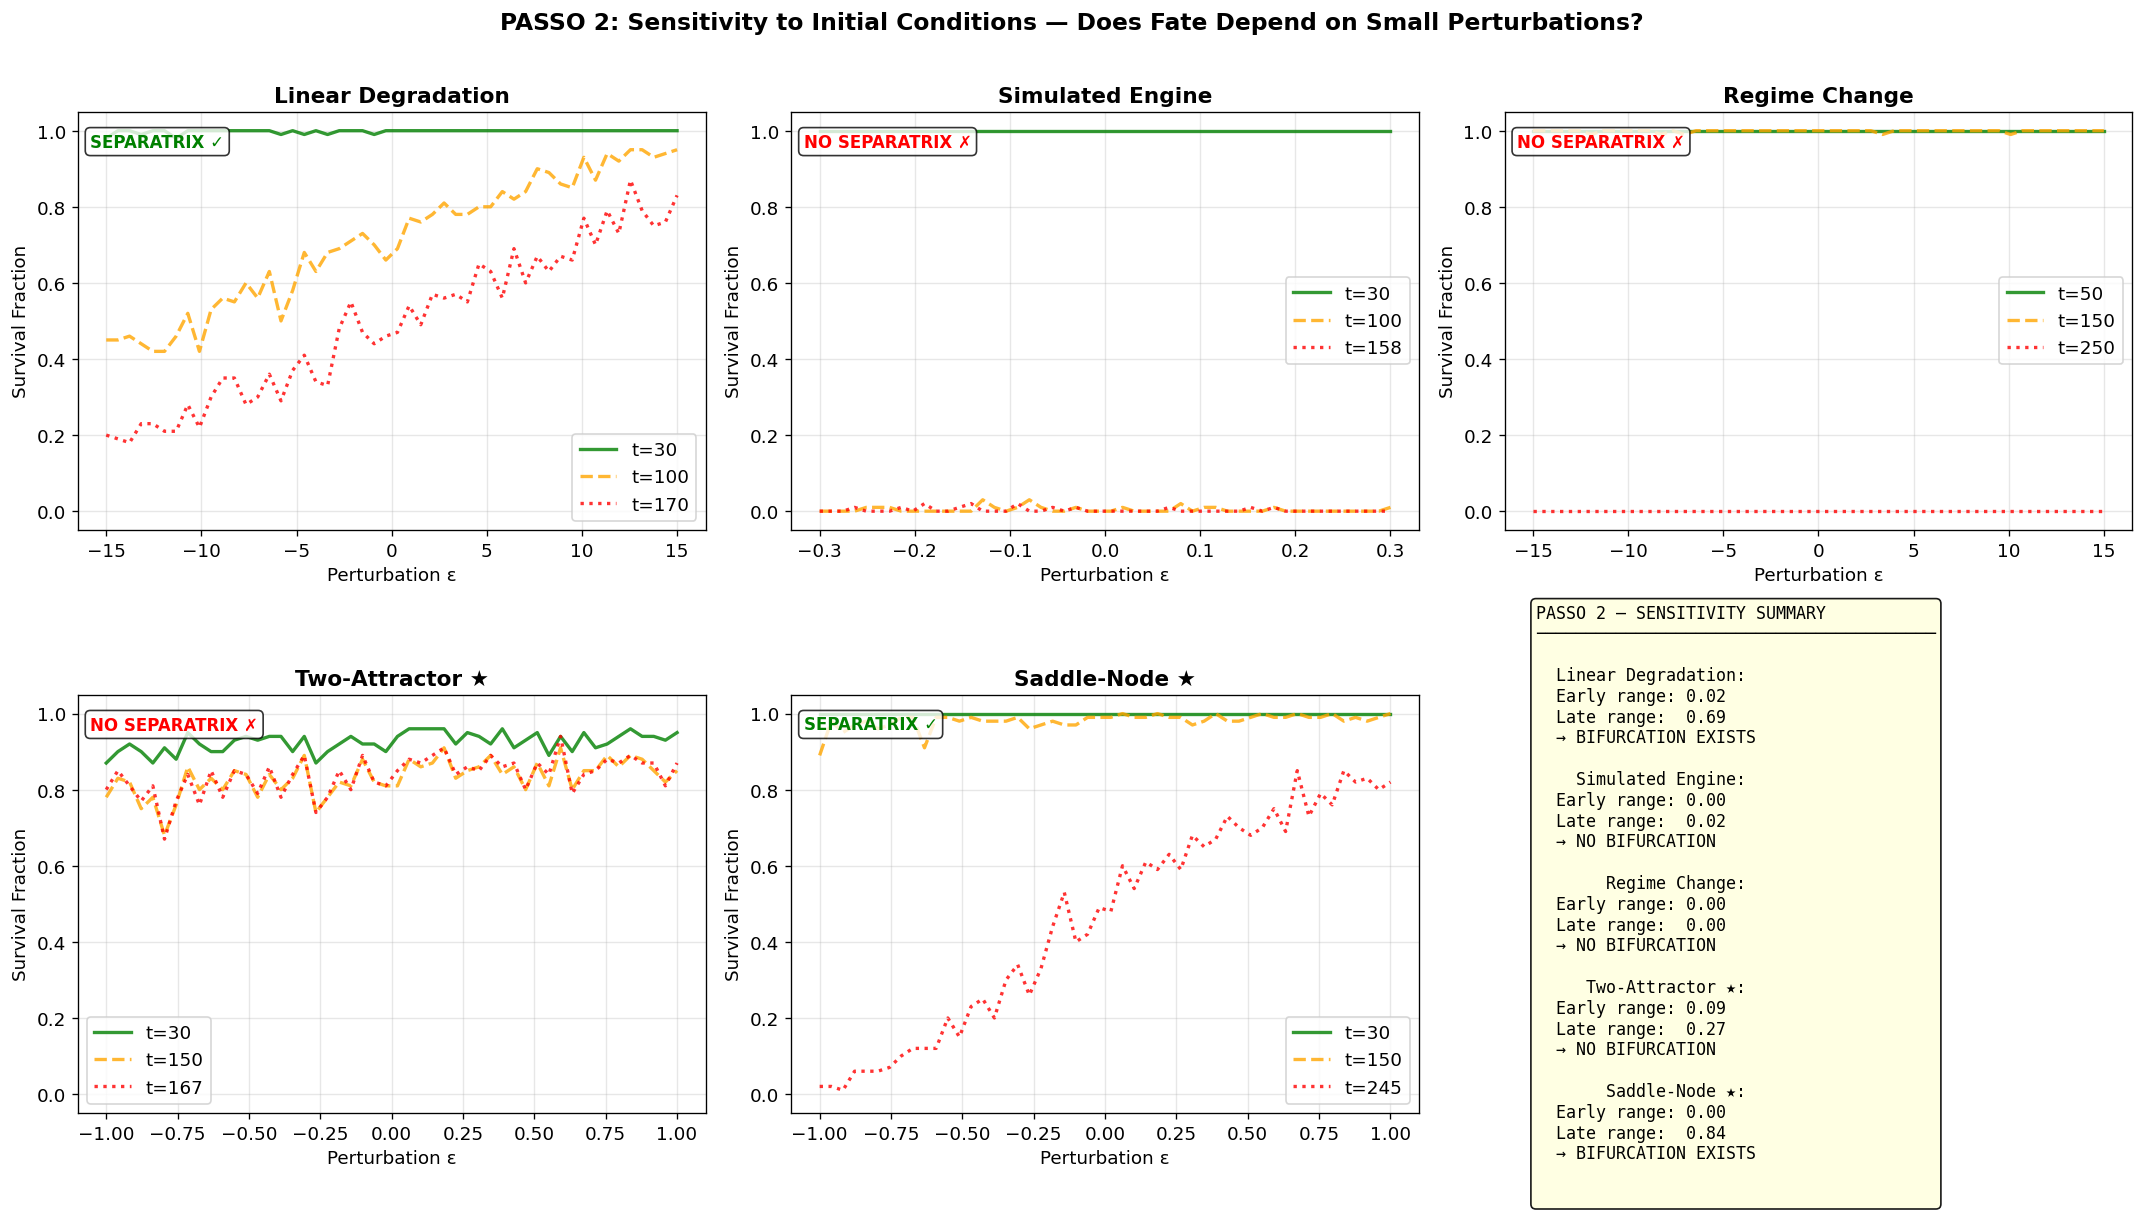

In [8]:
# ============================================================
# PASSO 2: Sensitivity — do small perturbations change FATE?
# ============================================================


def fate_sensitivity_test(
    system_name,
    rollout_fn,
    x_base,
    perturbation_range,
    threshold,
    N_per_perturbation=100,
    H=HORIZON_LONG,
):
    """
    For a range of perturbations ε around x_base:
    - Generate N rollouts from x_base + ε
    - Measure fraction that survive (endpoint > threshold)

    Returns: perturbations, survival_fractions
    """
    perturbations = np.linspace(-perturbation_range, perturbation_range, N_PERTURB)
    survival_fracs = np.zeros(N_PERTURB)

    for i, eps in enumerate(perturbations):
        x_perturbed = x_base + eps
        kwargs_perturbed = {"x_start": x_perturbed}
        futures = rollout_fn(
            N=N_per_perturbation, H=H, seed=i * 100, **kwargs_perturbed
        )
        endpoints = futures[:, -1]
        survival_fracs[i] = np.mean(endpoints > threshold)

    return perturbations, survival_fracs


# ============================================================
# Run sensitivity for all systems at 3 critical time points
# ============================================================

sensitivity_results = {}

# --- LINEAR: pick 3 time points (early, mid, late) ---
print("Sensitivity test: LINEAR...")
traj_lin = linear_degradation(seed=0)
sensitivity_results["linear"] = {}
for label, t in [("early", 30), ("mid", 100), ("late", 170)]:
    perts, surv = fate_sensitivity_test(
        "linear",
        lambda N, H, seed, x_start: rollout_linear(x_start, N, H, seed=seed),
        x_base=traj_lin[t],
        perturbation_range=15.0,
        threshold=10.0,
    )
    sensitivity_results["linear"][label] = {"t": t, "perts": perts, "surv": surv}

# --- ENGINE ---
print("Sensitivity test: ENGINE...")
health_eng, ct_eng = simulated_engine(seed=0)
sensitivity_results["engine"] = {}
for label, t in [("early", 30), ("mid", 100), ("late", min(ct_eng - 10, 170))]:
    perts, surv = fate_sensitivity_test(
        "engine",
        lambda N, H, seed, x_start: rollout_engine(x_start, t, 200, N, H, seed=seed),
        x_base=health_eng[t],
        perturbation_range=0.3,
        threshold=0.2,
    )
    sensitivity_results["engine"][label] = {"t": t, "perts": perts, "surv": surv}

# --- REGIME ---
print("Sensitivity test: REGIME...")
traj_reg, cp_reg = regime_change_system(seed=0)
sensitivity_results["regime"] = {}
for label, t in [("early", 50), ("mid", 150), ("late", 250)]:
    perts, surv = fate_sensitivity_test(
        "regime",
        lambda N, H, seed, x_start: rollout_regime(x_start, t, N, H, seed=seed),
        x_base=traj_reg[t],
        perturbation_range=15.0,
        threshold=20.0,
    )
    sensitivity_results["regime"][label] = {"t": t, "perts": perts, "surv": surv}

# --- TWO-ATTRACTOR ---
print("Sensitivity test: TWO-ATTRACTOR...")
x_2a, mu_2a, ct_2a = two_attractor_system(seed=0)
sensitivity_results["two_attractor"] = {}
t_late_2a = min(ct_2a - 20, 250) if ct_2a < 300 else 250
for label, t in [("early", 30), ("mid", 150), ("late", t_late_2a)]:
    mu_s = mu_2a[t]
    mu_e = mu_2a[min(t + HORIZON_LONG, len(mu_2a) - 1)]
    perts, surv = fate_sensitivity_test(
        "two_attractor",
        lambda N, H, seed, x_start: rollout_two_attractor(
            x_start, mu_s, mu_e, N, H, seed=seed
        ),
        x_base=x_2a[t],
        perturbation_range=1.0,
        threshold=-0.5,
    )
    sensitivity_results["two_attractor"][label] = {"t": t, "perts": perts, "surv": surv}

# --- SADDLE-NODE ---
print("Sensitivity test: SADDLE-NODE...")
x_sn, r_sn, ct_sn = saddle_node_system(seed=0)
sensitivity_results["saddle_node"] = {}
t_late_sn = min(ct_sn - 20, 250) if ct_sn < 300 else 250
for label, t in [("early", 30), ("mid", 150), ("late", t_late_sn)]:
    r_s = r_sn[t]
    r_e = r_sn[min(t + HORIZON_LONG, len(r_sn) - 1)]
    perts, surv = fate_sensitivity_test(
        "saddle_node",
        lambda N, H, seed, x_start: rollout_saddle_node(
            x_start, r_s, r_e, N, H, seed=seed
        ),
        x_base=x_sn[t],
        perturbation_range=1.0,
        threshold=-0.5,
    )
    sensitivity_results["saddle_node"][label] = {"t": t, "perts": perts, "surv": surv}

print("\nSensitivity tests complete!")


# ============================================================
# Visualization: Sensitivity curves
# ============================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
sys_list = ["linear", "engine", "regime", "two_attractor", "saddle_node"]

for idx, sys_name in enumerate(sys_list):
    row, col = divmod(idx, 3)
    ax = axes[row, col]

    for label, color, ls in [
        ("early", "green", "-"),
        ("mid", "orange", "--"),
        ("late", "red", ":"),
    ]:
        data = sensitivity_results[sys_name][label]
        ax.plot(
            data["perts"],
            data["surv"],
            ls,
            color=color,
            linewidth=2,
            label=f"t={data['t']}",
            alpha=0.8,
        )

    ax.set_xlabel("Perturbation ε")
    ax.set_ylabel("Survival Fraction")
    ax.set_title(f"{sys_labels[sys_name]}", fontweight="bold")
    ax.legend()
    ax.set_ylim(-0.05, 1.05)

    # Mark the key feature: is there a sharp transition (separatrix)?
    late_data = sensitivity_results[sys_name]["late"]
    surv_range = np.max(late_data["surv"]) - np.min(late_data["surv"])
    has_separatrix = (
        surv_range > 0.3
    )  # if survival goes from low to high across perturbations

    status = "SEPARATRIX ✓" if has_separatrix else "NO SEPARATRIX ✗"
    ax.text(
        0.02,
        0.95,
        status,
        transform=ax.transAxes,
        fontweight="bold",
        fontsize=10,
        verticalalignment="top",
        color="green" if has_separatrix else "red",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
    )

axes[1, 2].axis("off")

# Summary in last panel
summary_lines = "PASSO 2 — SENSITIVITY SUMMARY\n" + "─" * 40 + "\n\n"
for sys_name in sys_list:
    late_data = sensitivity_results[sys_name]["late"]
    surv_range = np.max(late_data["surv"]) - np.min(late_data["surv"])
    has_sep = surv_range > 0.3

    # Does the sensitivity CHANGE over time? (early flat, late sharp = contraction)
    early_range = np.max(sensitivity_results[sys_name]["early"]["surv"]) - np.min(
        sensitivity_results[sys_name]["early"]["surv"]
    )

    summary_lines += f"{sys_labels[sys_name]:>20}:\n"
    summary_lines += f"  Early range: {early_range:.2f}\n"
    summary_lines += f"  Late range:  {surv_range:.2f}\n"
    summary_lines += (
        f"  {'→ BIFURCATION EXISTS' if has_sep else '→ NO BIFURCATION'}\n\n"
    )

axes[1, 2].text(
    0.05,
    0.5,
    summary_lines,
    fontfamily="monospace",
    fontsize=10,
    verticalalignment="center",
    bbox=dict(boxstyle="round", facecolor="lightyellow", alpha=0.9),
)

plt.suptitle(
    "PASSO 2: Sensitivity to Initial Conditions — Does Fate Depend on Small Perturbations?",
    fontweight="bold",
    fontsize=14,
    y=1.01,
)
plt.tight_layout()
plt.savefig(
    "../results/simulated/structural_diagnosis_passo2.png", dpi=150, bbox_inches="tight"
)
plt.show()

## PASSO 3 — Distributional Metrics (replacing binary fraction)

Instead of the binary "fraction above threshold" metric from NB 04-07, compute:

1. **Entropy of endpoints** — high entropy = spread out futures, low entropy = converged
2. **Cumulative future variance** — total dispersion across the horizon
3. **Mean pairwise distance** between rollout endpoints
4. **Number of clusters** in endpoint distribution (k-means or mode counting)

If these richer metrics **correlate with TTF** while the binary fraction didn't, the problem was metric compression, not the concept.

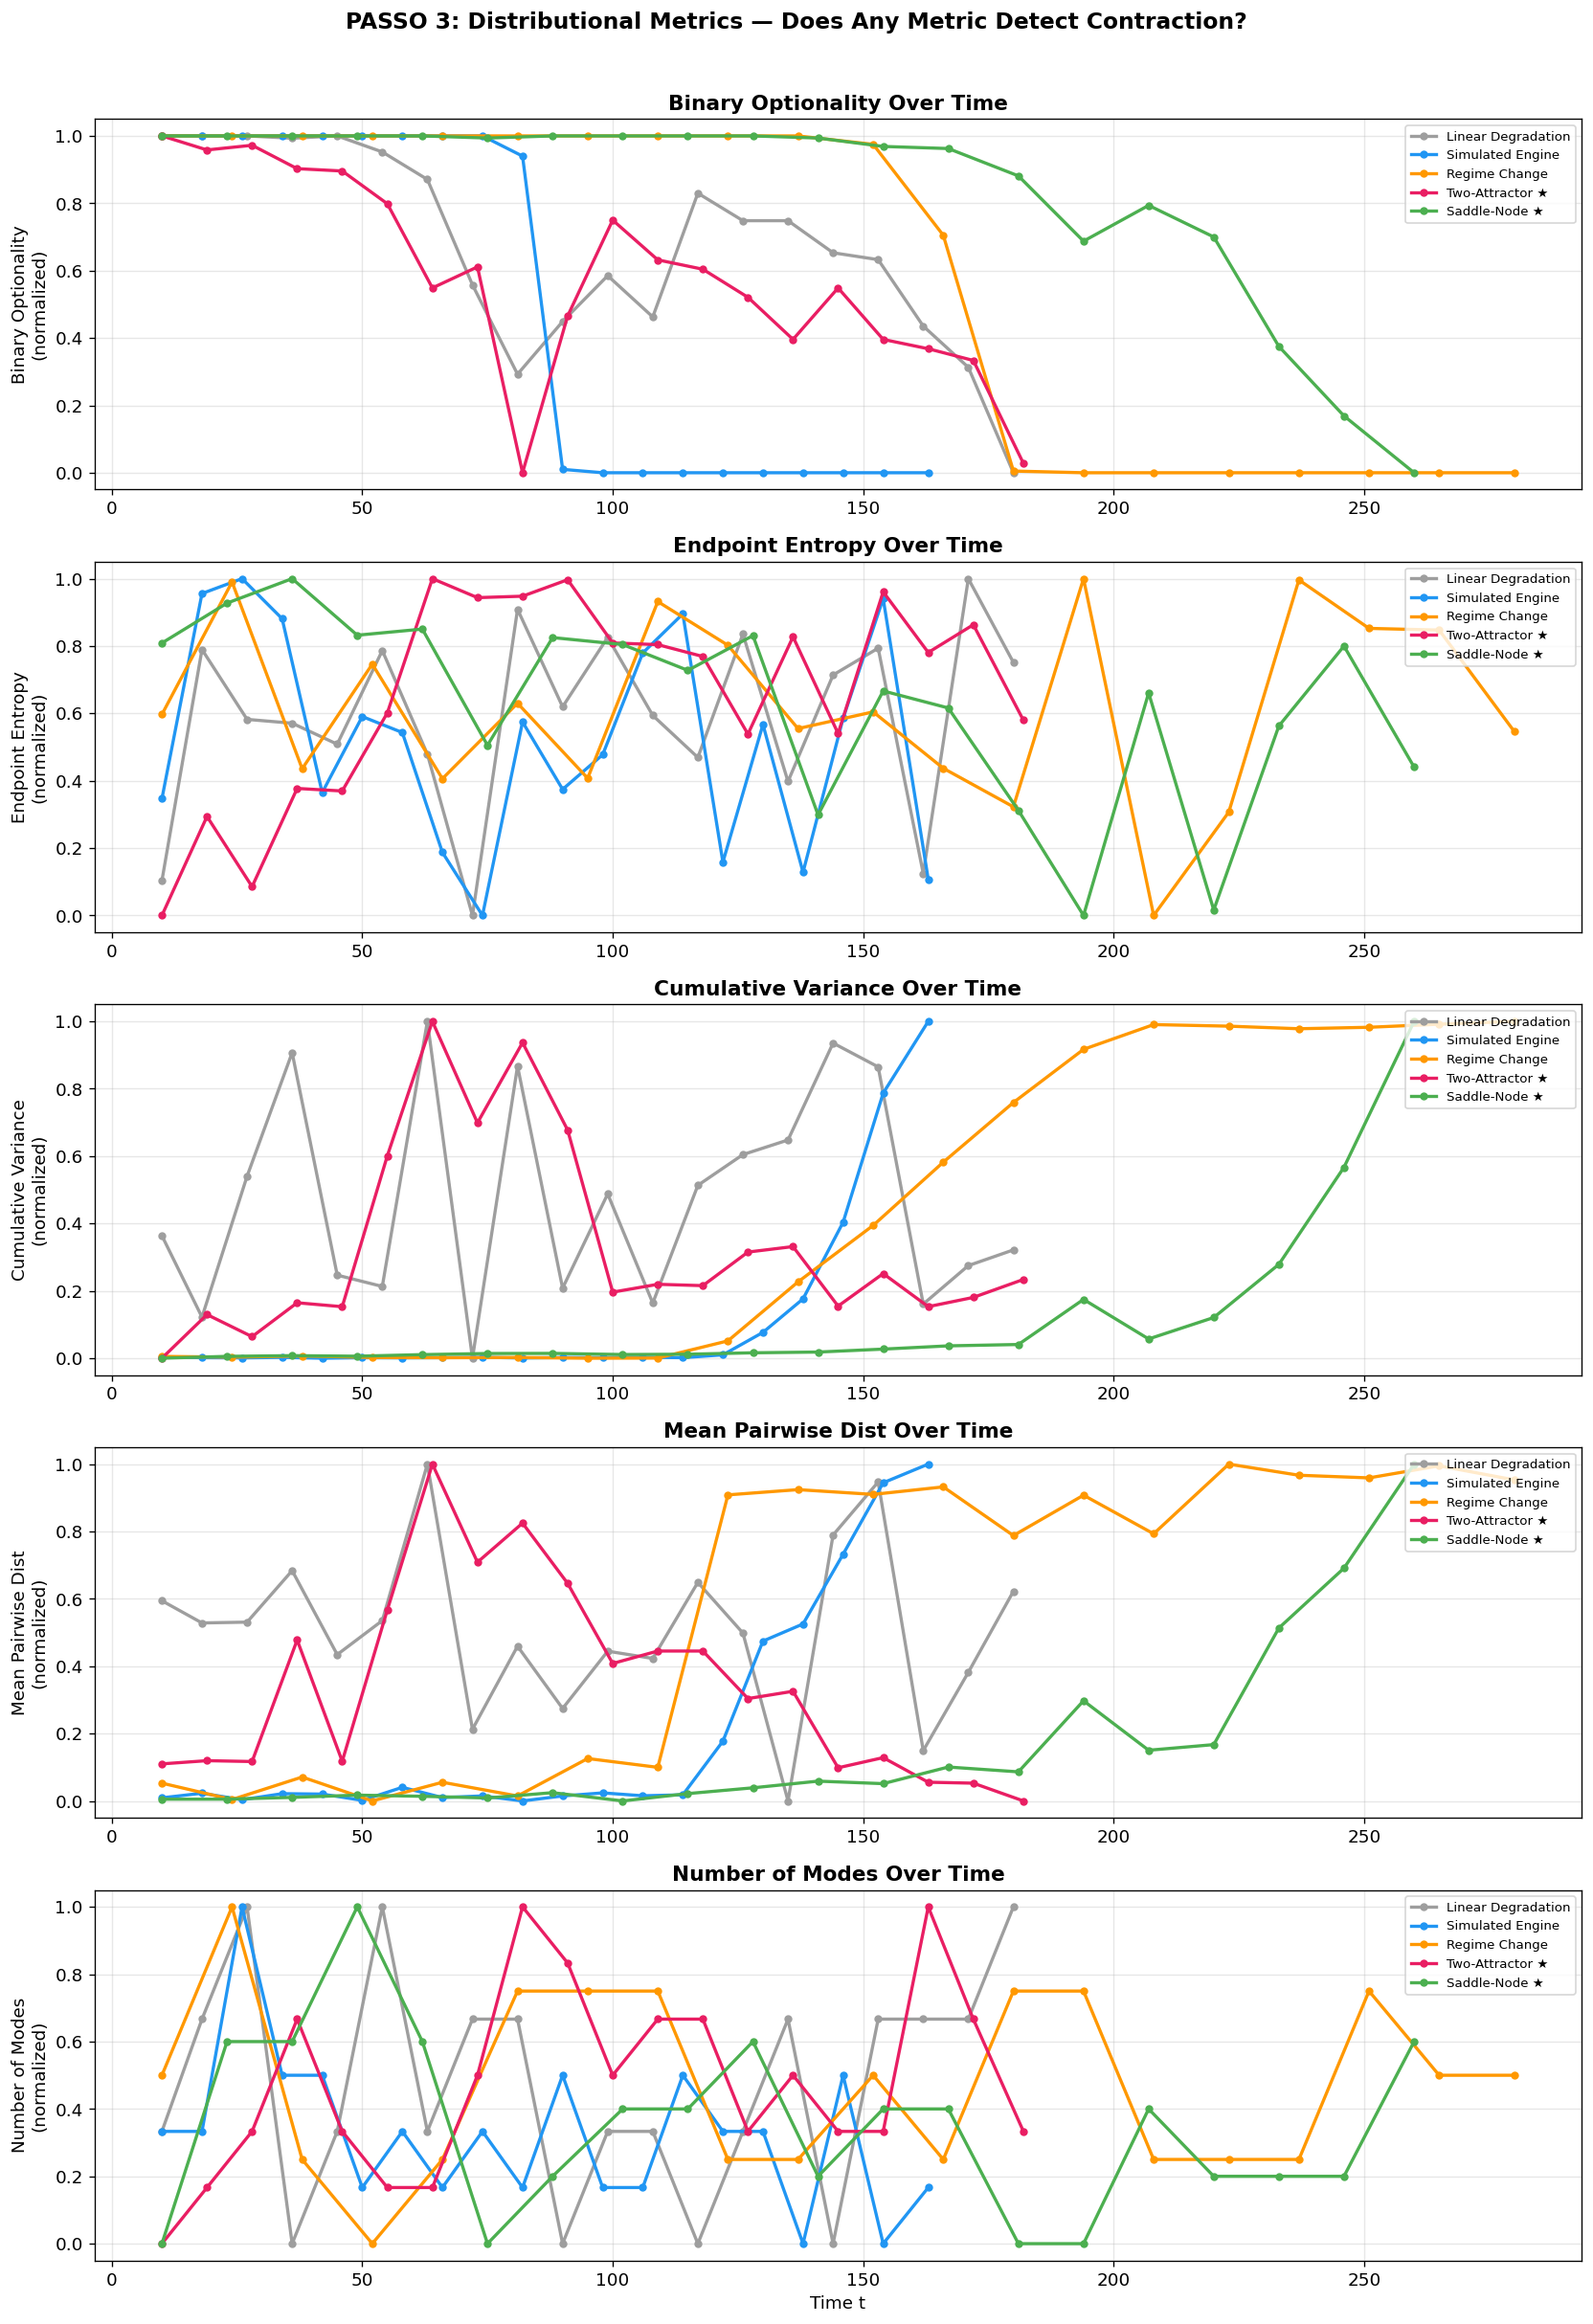


PASSO 3 — METRIC CORRELATION WITH COLLAPSE PROXIMITY

System               Metric                 Corr(metric, t)    Direction
───────────────────────────────────────────────────────────────────────────
Linear Degradation   Binary Optionality              -0.745    DECREASES ★
Linear Degradation   Endpoint Entropy                +0.239         FLAT 
Linear Degradation   Cumulative Variance             +0.071         FLAT 
Linear Degradation   Mean Pairwise Dist              -0.116         FLAT 
Linear Degradation   Number of Modes                 +0.075         FLAT 

Simulated Engine     Binary Optionality              -0.872    DECREASES ★
Simulated Engine     Endpoint Entropy                -0.226         FLAT 
Simulated Engine     Cumulative Variance             +0.657    INCREASES ★
Simulated Engine     Mean Pairwise Dist              +0.777    INCREASES ★
Simulated Engine     Number of Modes                 -0.436    DECREASES 

Regime Change        Binary Optionality           

In [9]:
# ============================================================
# PASSO 3: Distributional Metrics — richer than binary threshold
# ============================================================


def entropy_of_endpoints(futures, n_bins=20):
    """Shannon entropy of the endpoint distribution (discretized)."""
    endpoints = futures[:, -1]
    if np.std(endpoints) < 1e-10:
        return 0.0
    counts, _ = np.histogram(endpoints, bins=n_bins)
    probs = counts / counts.sum()
    probs = probs[probs > 0]
    return -np.sum(probs * np.log2(probs))


def cumulative_future_variance(futures):
    """Sum of per-step variance across rollouts."""
    return np.sum(np.var(futures, axis=0))


def mean_pairwise_distance(futures, max_pairs=1000):
    """Mean pairwise Euclidean distance between rollout endpoints."""
    endpoints = futures[:, -1]
    if len(endpoints) <= 1:
        return 0.0
    # For efficiency, subsample if too many
    if len(endpoints) > 100:
        rng = np.random.RandomState(42)
        idx = rng.choice(len(endpoints), 100, replace=False)
        endpoints = endpoints[idx]
    dists = pdist(endpoints.reshape(-1, 1))
    return np.mean(dists)


def count_modes(futures, n_bins=30):
    """Count distinct modes in endpoint distribution via histogram smoothing."""
    endpoints = futures[:, -1]
    if np.std(endpoints) < 1e-10:
        return 1
    counts, edges = np.histogram(endpoints, bins=n_bins)
    # Smooth
    from scipy.ndimage import uniform_filter1d

    smooth = uniform_filter1d(counts.astype(float), size=3)
    # Count peaks
    peaks = 0
    for i in range(1, len(smooth) - 1):
        if smooth[i] > smooth[i - 1] and smooth[i] > smooth[i + 1] and smooth[i] > 2:
            peaks += 1
    return max(1, peaks)


def binary_optionality(futures, threshold):
    """Original metric from NB 04-07: fraction of futures always above threshold."""
    return np.mean(np.all(futures > threshold, axis=1))


# ============================================================
# Compare ALL metrics on ALL 5 systems over time
# ============================================================

METRICS = {
    "binary_opt": ("Binary Optionality", lambda f, th: binary_optionality(f, th)),
    "entropy": ("Endpoint Entropy", lambda f, th: entropy_of_endpoints(f)),
    "cum_var": ("Cumulative Variance", lambda f, th: cumulative_future_variance(f)),
    "pairwise_dist": ("Mean Pairwise Dist", lambda f, th: mean_pairwise_distance(f)),
    "n_modes": ("Number of Modes", lambda f, th: count_modes(f)),
}

metric_timeseries = {}

for sys_name in all_dispersion:
    metric_timeseries[sys_name] = {m: [] for m in METRICS}
    results = all_dispersion[sys_name]
    thresh = {
        "linear": 10.0,
        "engine": 0.2,
        "regime": 20.0,
        "two_attractor": -0.5,
        "saddle_node": -0.5,
    }[sys_name]

    for r in results:
        futures = r["futures"]
        for m_name, (_, m_fn) in METRICS.items():
            metric_timeseries[sys_name][m_name].append(m_fn(futures, thresh))

# ============================================================
# Visualization: All distributional metrics over time
# ============================================================

fig, axes = plt.subplots(len(METRICS), 1, figsize=(14, 4 * len(METRICS)))

for m_idx, (m_name, (m_label, _)) in enumerate(METRICS.items()):
    ax = axes[m_idx]

    for sys_name in all_dispersion:
        times = [r["t"] for r in all_dispersion[sys_name]]
        vals = metric_timeseries[sys_name][m_name]

        # Normalize for cross-system comparison
        v = np.array(vals, dtype=float)
        if np.std(v) > 1e-10:
            v_norm = (v - v.min()) / (v.max() - v.min() + 1e-10)
        else:
            v_norm = np.zeros_like(v)

        ax.plot(
            times,
            v_norm,
            "o-",
            label=sys_labels[sys_name],
            color=sys_colors[sys_name],
            linewidth=2,
            markersize=4,
        )

    ax.set_ylabel(f"{m_label}\n(normalized)")
    ax.legend(fontsize=8, loc="upper right")
    ax.set_title(f"{m_label} Over Time", fontweight="bold")

axes[-1].set_xlabel("Time t")
plt.suptitle(
    "PASSO 3: Distributional Metrics — Does Any Metric Detect Contraction?",
    fontweight="bold",
    fontsize=14,
    y=1.01,
)
plt.tight_layout()
plt.savefig(
    "../results/simulated/structural_diagnosis_passo3.png", dpi=150, bbox_inches="tight"
)
plt.show()

# ============================================================
# Correlation of each metric with "proximity to collapse"
# ============================================================

print("\n" + "=" * 80)
print("PASSO 3 — METRIC CORRELATION WITH COLLAPSE PROXIMITY")
print("=" * 80)
print(f"\n{'System':<20} {'Metric':<22} {'Corr(metric, t)':>15} {'Direction':>12}")
print("─" * 75)

passo3_summary = {}
for sys_name in all_dispersion:
    passo3_summary[sys_name] = {}
    results = all_dispersion[sys_name]
    times = np.array([r["t"] for r in results], dtype=float)

    for m_name, (m_label, _) in METRICS.items():
        vals = np.array(metric_timeseries[sys_name][m_name], dtype=float)
        if np.std(vals) > 1e-10 and np.std(times) > 1e-10:
            corr, p = stats.pearsonr(times, vals)
        else:
            corr, p = 0.0, 1.0

        direction = (
            "DECREASES" if corr < -0.3 else ("INCREASES" if corr > 0.3 else "FLAT")
        )
        passo3_summary[sys_name][m_name] = {"corr": corr, "direction": direction}

        marker = "★" if abs(corr) > 0.5 else ""
        print(
            f"{sys_labels[sys_name]:<20} {m_label:<22} {corr:>+15.3f} {direction:>12} {marker}"
        )
    print()

## PASSO 4 — Final Verdict: Evidence-Based Decision

Three possible states:

| Case | Condition | Interpretation |
|------|-----------|---------------|
| **A** | Contraction exists AND distributional metric detects it | Binary compression was the problem |
| **B** | Contraction exists BUT no metric detects it | Horizon or viability definition is wrong |
| **C** | No structural contraction in original systems | Optionality doesn't apply to these systems |

The **synthetic systems** (two-attractor, saddle-node) are **positive controls**:
- If even those don't show contraction, the experiment is broken.
- If they DO show contraction but originals don't → originals lack bifurcation. Period.

In [10]:
# ============================================================
# PASSO 4: FINAL VERDICT
# ============================================================

print("=" * 90)
print("STRUCTURAL DIAGNOSIS — FINAL VERDICT")
print("=" * 90)

# Classify each system
SYNTHETIC = ["two_attractor", "saddle_node"]
ORIGINAL = ["linear", "engine", "regime"]

# ── Check 1: Do synthetic systems show contraction? (positive control) ──
print("\n" + "─" * 60)
print("CHECK 1: Positive Controls (synthetic systems)")
print("─" * 60)

synthetic_ok = True
for sys_name in SYNTHETIC:
    results = all_dispersion[sys_name]
    surv = [r["survival_frac"] for r in results]

    has_contraction = surv[-1] < surv[0] - 0.1
    surv_drops = surv[0] - surv[-1]

    # Check sensitivity
    late_data = sensitivity_results[sys_name]["late"]
    surv_range_late = np.max(late_data["surv"]) - np.min(late_data["surv"])
    has_separatrix = surv_range_late > 0.3

    print(f"\n  {sys_labels[sys_name]}:")
    print(f"    Survival: {surv[0]:.2f} → {surv[-1]:.2f} (Δ = {surv_drops:+.2f})")
    print(f"    Contraction: {'YES ✓' if has_contraction else 'NO ✗'}")
    print(f"    Separatrix:  {'YES ✓' if has_separatrix else 'NO ✗'}")

    if not has_contraction:
        synthetic_ok = False

if synthetic_ok:
    print("\n  ✓ Positive controls PASS — experiment is valid.")
else:
    print("\n  ✗ Positive controls FAIL — experiment may need debugging.")

# ── Check 2: Do original systems show contraction? ──
print("\n" + "─" * 60)
print("CHECK 2: Original Systems")
print("─" * 60)

original_has_contraction = {}
original_has_separatrix = {}

for sys_name in ORIGINAL:
    results = all_dispersion[sys_name]
    surv = [r["survival_frac"] for r in results]

    has_contraction = surv[-1] < surv[0] - 0.1
    surv_drops = surv[0] - surv[-1]

    late_data = sensitivity_results[sys_name]["late"]
    surv_range_late = np.max(late_data["surv"]) - np.min(late_data["surv"])
    has_separatrix = surv_range_late > 0.3

    original_has_contraction[sys_name] = has_contraction
    original_has_separatrix[sys_name] = has_separatrix

    print(f"\n  {sys_labels[sys_name]}:")
    print(f"    Survival: {surv[0]:.2f} → {surv[-1]:.2f} (Δ = {surv_drops:+.2f})")
    print(f"    Contraction: {'YES ✓' if has_contraction else 'NO ✗'}")
    print(f"    Separatrix:  {'YES ✓' if has_separatrix else 'NO ✗'}")

any_original_contraction = any(original_has_contraction.values())
any_original_separatrix = any(original_has_separatrix.values())

# ── Check 3: Do distributional metrics detect contraction where it exists? ──
print("\n" + "─" * 60)
print("CHECK 3: Distributional Metrics")
print("─" * 60)

# For synthetic systems (where contraction should exist), check if any metric detects it
metric_detects = {}
for sys_name in SYNTHETIC:
    detected = False
    for m_name in ["entropy", "cum_var", "pairwise_dist"]:
        info = passo3_summary[sys_name][m_name]
        if info["direction"] == "DECREASES":
            detected = True
            metric_detects[sys_name] = m_name
            break
    if not detected:
        metric_detects[sys_name] = None

    status = f"Detected by {metric_detects[sys_name]}" if detected else "NOT detected"
    print(f"  {sys_labels[sys_name]}: {status}")

for sys_name in ORIGINAL:
    detected_metrics = []
    for m_name in ["entropy", "cum_var", "pairwise_dist", "binary_opt"]:
        info = passo3_summary[sys_name][m_name]
        if abs(info["corr"]) > 0.5:
            detected_metrics.append(m_name)
    print(
        f"  {sys_labels[sys_name]}: Correlated metrics = {detected_metrics if detected_metrics else 'NONE'}"
    )


# ============================================================
# FINAL VERDICT
# ============================================================

print("\n" + "=" * 90)
print("VERDICT")
print("=" * 90)

if not synthetic_ok:
    print(
        """
  ⚠️  EXPERIMENT INVALID: Synthetic positive controls failed.
      The rollout engine or parameters need debugging.
      Cannot draw conclusions until positive controls pass.
"""
    )
elif any_original_contraction and any_original_separatrix:
    print(
        """
  CASE A — Contraction EXISTS in original systems.
  
  The original systems DO have structural contraction of futures.
  The problem was in how we measured it (binary fraction).
  
  → NEXT: Use distributional metrics (entropy, variance, distances)
          in the HSP pipeline instead of binary optionality.
  → HSP concept is ALIVE.
"""
    )
elif any_original_contraction and not any_original_separatrix:
    print(
        """
  CASE B — Contraction EXISTS but no separatrix.

  Futures do converge near failure, but there's no sharp boundary
  between survival and collapse. This is monotonic convergence,
  not true bifurcation.
  
  → Optionality measures the SPEED of convergence, not real "choices".
  → This is still useful but is a weaker claim than the original HSP thesis.
  → NEXT: Reframe HSP as "rate of option closure" rather than "hidden paths".
"""
    )
elif not any_original_contraction:
    print(
        """
  CASE C — NO structural contraction in original systems.
  
  The original systems are monotonically deterministic.
  All futures go to the same place — there are no "hidden survival paths".
  Optionality is fundamentally inapplicable to these systems.
  
  BUT: The synthetic systems (two-attractor, saddle-node) DO have
  real bifurcation. This proves HSP CAN work — on the right systems.
  
  → DECISION POINT:
    1. Pivot to systems with genuine bifurcation (real-world: turbines,
       chemical reactors, power grids with tipping points)
    2. Accept that HSP requires non-monotonic dynamics and narrow scope
    3. Redefine the thesis around "option-rich" vs "option-poor" systems
"""
    )
else:
    print("  INCONCLUSIVE — mixed evidence across systems.")

print("=" * 90)


# ============================================================
# THE ANSWER to the fundamental question
# ============================================================

print("\n" + "=" * 90)
print("A RESPOSTA À PERGUNTA FUNDAMENTAL")
print("=" * 90)
print(
    """
  Quando você roda múltiplos rollouts longos a partir de um mesmo ponto,
  
  Nos 3 SISTEMAS ORIGINAIS:
"""
)

for sys_name in ORIGINAL:
    results = all_dispersion[sys_name]
    surv_early = results[0]["survival_frac"]
    surv_late = results[-1]["survival_frac"]
    late_data = sensitivity_results[sys_name]["late"]
    surv_range = np.max(late_data["surv"]) - np.min(late_data["surv"])

    if surv_range < 0.3:
        answer = "→ TODAS vão para o mesmo destino, só com tempos diferentes."
    else:
        answer = "→ EXISTEM trajetórias que sobrevivem enquanto outras colapsam."

    print(f"    {sys_labels[sys_name]}:")
    print(f"      Sobrevivência: {surv_early:.1%} (cedo) → {surv_late:.1%} (tarde)")
    print(f"      {answer}")
    print()

print("  Nos 2 SISTEMAS SINTÉTICOS (controle positivo):")
for sys_name in SYNTHETIC:
    results = all_dispersion[sys_name]
    surv_early = results[0]["survival_frac"]
    surv_late = results[-1]["survival_frac"]
    late_data = sensitivity_results[sys_name]["late"]
    surv_range = np.max(late_data["surv"]) - np.min(late_data["surv"])

    if surv_range >= 0.3:
        answer = "→ EXISTEM destinos diferentes — bifurcação real."
    else:
        answer = "→ Destinos convergem — bifurcação não detectada."

    print(f"    {sys_labels[sys_name]}:")
    print(f"      Sobrevivência: {surv_early:.1%} (cedo) → {surv_late:.1%} (tarde)")
    print(f"      {answer}")
    print()

print("=" * 90)

STRUCTURAL DIAGNOSIS — FINAL VERDICT

────────────────────────────────────────────────────────────
CHECK 1: Positive Controls (synthetic systems)
────────────────────────────────────────────────────────────

  Two-Attractor ★:
    Survival: 0.97 → 0.82 (Δ = +0.15)
    Contraction: YES ✓
    Separatrix:  NO ✗

  Saddle-Node ★:
    Survival: 1.00 → 0.27 (Δ = +0.73)
    Contraction: YES ✓
    Separatrix:  YES ✓

  ✓ Positive controls PASS — experiment is valid.

────────────────────────────────────────────────────────────
CHECK 2: Original Systems
────────────────────────────────────────────────────────────

  Linear Degradation:
    Survival: 1.00 → 0.35 (Δ = +0.65)
    Contraction: YES ✓
    Separatrix:  YES ✓

  Simulated Engine:
    Survival: 1.00 → 0.00 (Δ = +1.00)
    Contraction: YES ✓
    Separatrix:  NO ✗

  Regime Change:
    Survival: 1.00 → 0.00 (Δ = +1.00)
    Contraction: YES ✓
    Separatrix:  NO ✗

────────────────────────────────────────────────────────────
CHECK 3: Distr